# Семинар 10: Классификация

# Что мы будем делать? 

1. Посмотрим на данные, поймем что хотим прогнозировать 
2. Посмотрим есть ли в данных пропуски, обработаем их
3. Проскалируем переменные 
4. Подготовм переменную для прогнозирования, посмотрим есть ли с ней проблемы 
5. Построим строить модели, построим насколько они хороши по метрикам 


In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами

import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import matplotlib
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')           # правильный (очень красивый) стиль у графиков

%matplotlib inline

# 1. Данные и пропуски 

Рассмотрим данные для клипов с youtube. Попробуем предсказывать жарн видео по его параметрам. 

In [2]:
data = pd.read_csv('youtube_data.csv', sep = '\t')
data.head()

,title,caption,categoryId,commentCount,definition,description,dislikeCount,duration,license,licensedContent,...,comment_mean_len_symbol,comment_mean_len_word,comment_negative_mean_prob,comment_negative_share,commentators_uniq,comments_emoji_max,comments_emoji_mean,comments_emoji_share,comments_obscene_cnt,words_obscene_cnt
0,"""#2Маши ""Свободные линии""",False,10,34.0,hd,ITUNES - https://itun.es/ru/0YzI_,43.0,PT3M30S,youtube,True,...,59.440000,8.840000,0.635410,0.480000,24.0,9.0,1.000000,0.320000,0.0,0.0
1,"""ALARM"" СЕРГЕЙ ЛАЗАРЕВ ( SERGEY LAZAREV )",False,10,NaN,sd,NEW OFFICIAL VIDEO\r\n2010,690.0,PT3M42S,youtube,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"""EARTH SONG"" SERGEY LAZAREV. DEDICATED TO MIC...",False,10,26.0,sd,Посвящается Майклу Джексону...\r\nCover-versio...,10.0,PT5M46S,youtube,False,...,120.000000,19.291667,0.725987,0.750000,23.0,13.0,0.666667,0.125000,0.0,0.0
3,"""Earth song"" премия МУЗ-тВ 2010 (LIVE)",False,10,12.0,sd,"Сергей Лазарев, La Toya Jackson, Ани Лорак, Т...",7.0,PT6M16S,youtube,False,...,81.818182,11.545455,0.736776,0.727273,11.0,13.0,1.181818,0.090909,0.0,0.0
4,"""FAKE"" СЕРГЕЙ ЛАЗАРЕВ (SERGEY)",False,10,46.0,sd,official video,19.0,PT3M,youtube,True,...,43.735294,8.617647,0.596008,0.441176,33.0,23.0,0.794118,0.088235,1.0,1.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19124 entries, 0 to 19123
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       19124 non-null  object 
 1   caption                     19124 non-null  bool   
 2   categoryId                  19124 non-null  int64  
 3   commentCount                18914 non-null  float64
 4   definition                  19124 non-null  object 
 5   description                 18339 non-null  object 
 6   dislikeCount                18850 non-null  float64
 7   duration                    19124 non-null  object 
 8   license                     19124 non-null  object 
 9   licensedContent             19124 non-null  bool   
 10  likeCount                   18850 non-null  float64
 11  music_style                 19124 non-null  object 
 12  performer                   19124 non-null  object 
 13  publicStatsViewable         191

Можно заметить, что некоторые данные у нас отсутствуют. Давайте посмотрим на заполненность нашей таблички на картинке. 

Что мы говорим пропускам в данных? Не сегодня. С пропусками нужно бороться. Алгоритмы оцениваются на числах и не любят пропуски (некоторые настроены к пропускам нейтрально, так как умеют их обрабатывать). 

Первое решение: выбросить все наблюдения с пропусками. Проблема такого подхода в том, что другие то переменные для этих наблюдений не пропущены. Значит, выбросив строчки, соответствующие пропускам, мы потеряем кучу информации. Полезной информации. Информацию и без всех наших преобразований легко потерять, сложно найти и невозможно забыть, а мы её ещё и выкинуть хотим. 

Обычно, если пропусков в переменной не очень много, их заполняют чем-нибудь нейтральным. Например, средними или медианами. Когда алгоритм будет натыкаться на них, он будет думать: "Хммм, ну тут ничего особенного, всё как в среднем по выборке, пойду посмотрю другую переменную". И тогда всё будет хорошо. 

# fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

Для удобства создаём список из непрерывных переменных. Дальше будем работать только с ними.

In [7]:
real_variables = ["commentCount",              # число комментов под видосом
                  "dislikeCount",              # число дисолайков 
                  "likeCount",                 # лайки 
                  "viewCount",                 # просмотры 
                  "comment_max_len_symbol",    # максимальная длинна комента 
                  "comment_max_len_word",      # максимальное число слов в коменте 
                  "comment_mean_len_symbol",   # средняя длина комента
                  "comment_mean_len_word",     # среднее число слов в коменте 
                  "comment_negative_share",    # средяя доля негатива в коментах 
                  "comment_negative_mean_prob",# ещё одна переменная, отвечающая за негатив
                  "commentators_uniq",         # число уникальных коментаторов 
                  "comments_emoji_max",        # максимальное число эмодзи в коменте
                  "comments_emoji_mean",       # среднее число эмодзи 
                  "comments_emoji_share",      # доля коментов с эмодзи 
                  "comments_obscene_cnt",      # число матерных коментов 
                  "words_obscene_cnt"          # число матерных слов под видосом
                 ]

Давайте заполним во всех непрерывных переменных пропуски средними. 

In [11]:
for col in real_variables: 
    data[col] = data[col].fillna(data[col].mean())

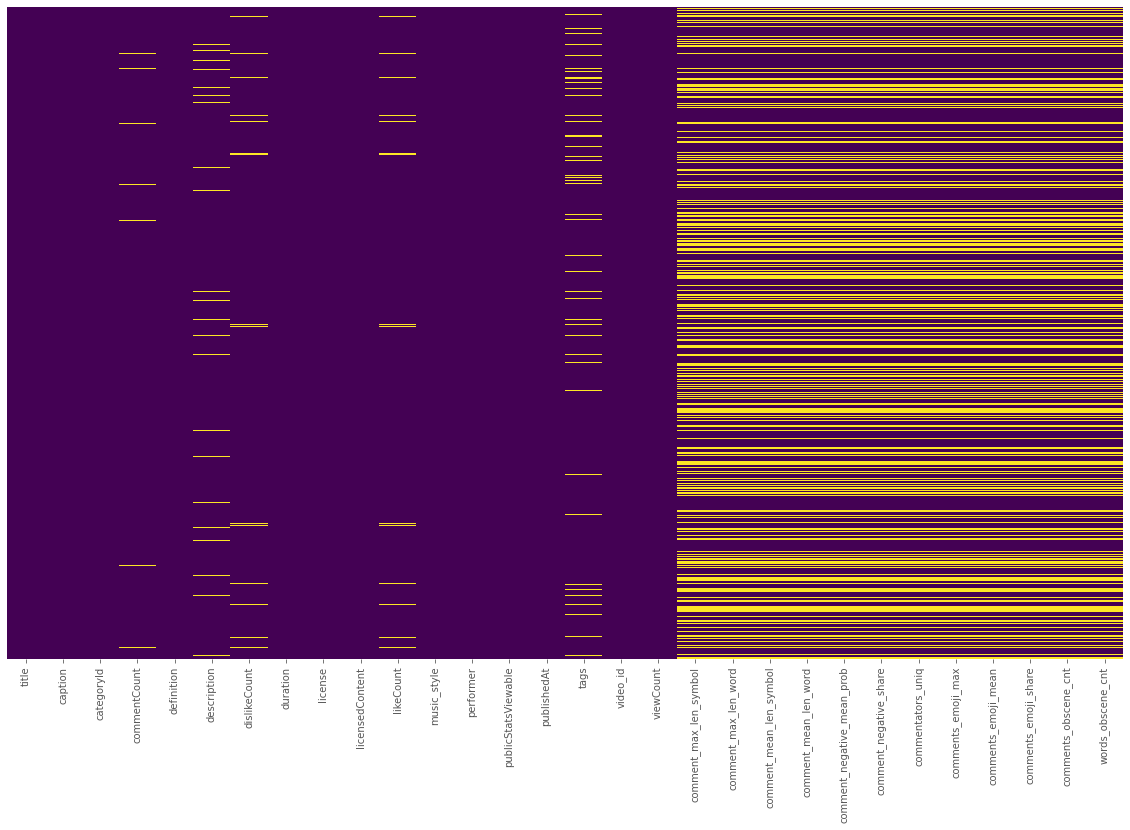

In [4]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis') 

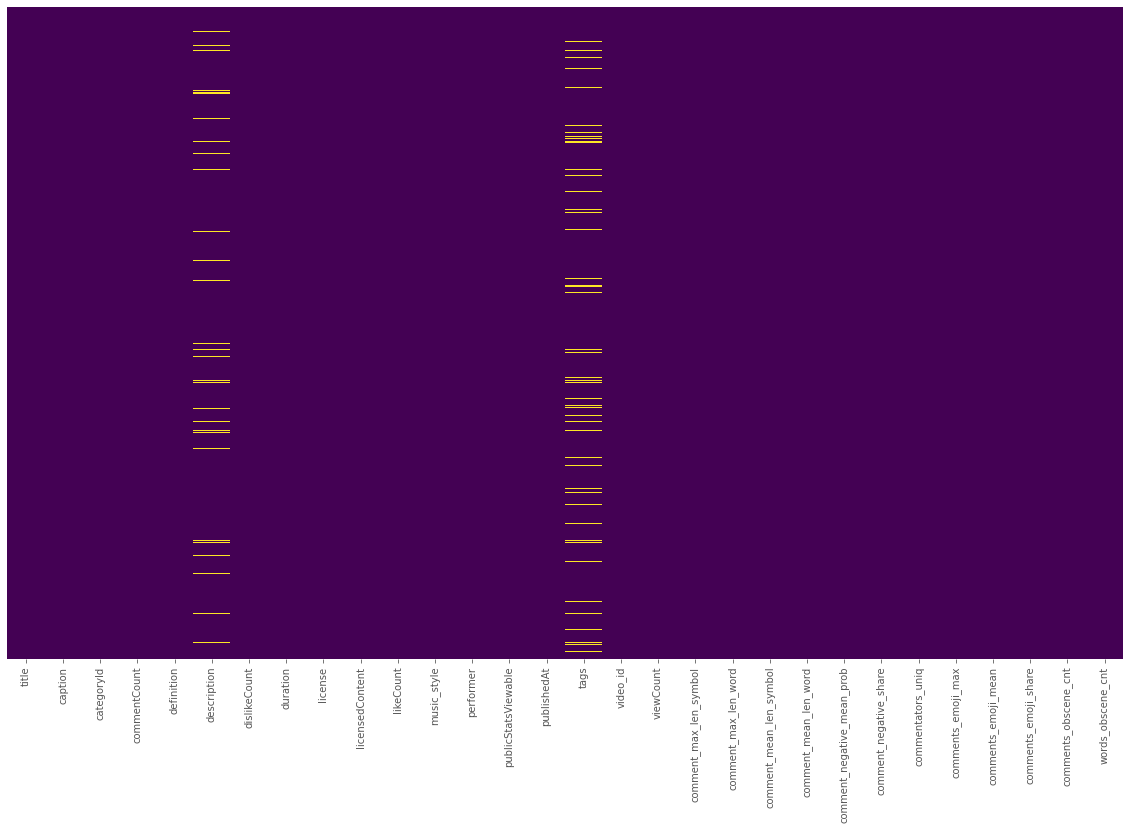

In [12]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')


Посмотрим на распределение переменных

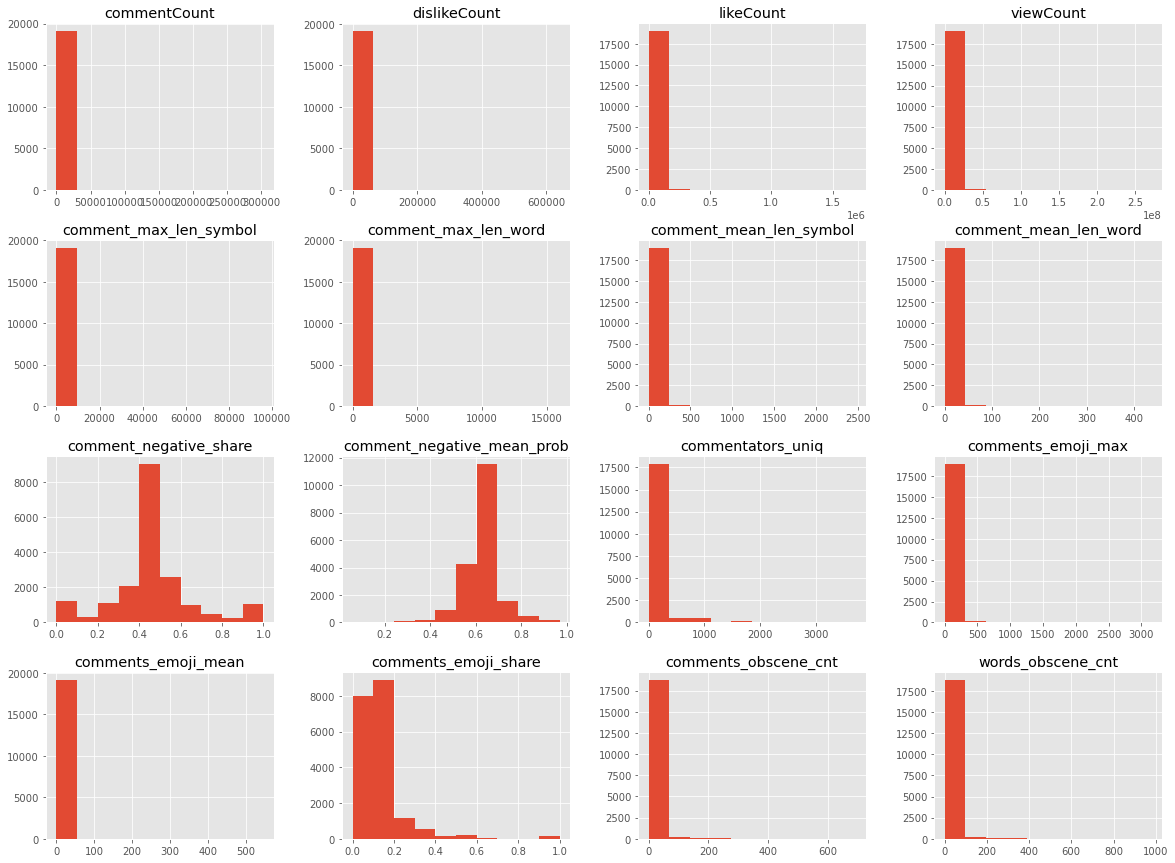

In [14]:
data[real_variables].hist(figsize = (20, 15));
    

# 2. Что будем предсказывать? 

Предсказывать будем жанр видео. Давайте посмотрим какие у нас есть жанры в данных. 

In [15]:
data.music_style.value_counts()

rock       5888
estrada    4151
popsa      3339
shanson    2061
rap        2028
indi       1359
classic     298
Name: music_style, dtype: int64

Давайте для простоты оставим в данных только два жанра. Например, рэпчик и эстраду (Киркоров и компания). Попробуем заставить машины разбираться что за видос перед ними. 

In [16]:
data = data[(data.music_style == 'estrada') | (data.music_style == 'rap')]

Разбиваем выборку на обучающую, в которой мы будем находить закономерности, и тестовую выборку, на которой мы будем проверять выявленные закономерности.

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2, random_state=201905, stratify=data['music_style'])

print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

Размер обучающей выборки: (4943, 30)
Размер тестовой выборки: (1236, 30)


Убедимся, что мы не нарушили пропорции жанров при делении выборки на тренировочную и тестову. __Как думаете, зачем это нужно?__ 

In [18]:
train.music_style.value_counts()/train.shape[0]

estrada    0.671859
rap        0.328141
Name: music_style, dtype: float64

In [19]:
test.music_style.value_counts()/test.shape[0]

estrada    0.671521
rap        0.328479
Name: music_style, dtype: float64

Вроде бы всё нормально. Сейчас в нашем датасете все жанры записаны в текстовом виде. Мы с вами постоянно повторяем, как прописную истину то, что __модели поедают только цифры.__ Давайте переработаем жанры в дамми-переменную. Будем обозначать рэпчик за $1$, попсу за $0$. 

In [20]:
y_train = 1 * (train.music_style.to_numpy() == 'rap')
y_train

array([1, 1, 1, ..., 1, 0, 0])

In [21]:
y_test = 1 * (test.music_style.to_numpy() == 'rap')
y_test

array([0, 0, 0, ..., 1, 0, 0])

# 3. Моделирование! 

Давайте строить прогнозные модели! 

## 3.1 k Nearest Neighbours (метод ближайших соседей) 

**KNN** - один из базовых и максимально наглядных алгоритмов. Среди уже известных нам объектов находятся $k$ максимально похожих на наш неизвестный объект (соседей). Неизвестному объекту проставляется тот класс, который наиболее широко представлен среди его соседей. 

Возьмем все числовые данные из нашего набора.

In [22]:
X_train = train[real_variables].to_numpy()
X_test = test[real_variables].to_numpy()

Наконец-то мы можем начать учить модели. Подгружаем метод ближайших соседей из пакета. 

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# объявляем метод 5 ближайших соседей
knn = KNeighborsClassifier(n_neighbors = 5)

# обучаем его по тренировочные выборке 
knn.fit(X_train, y_train)

# строим для тестовой выборки прогнозы 
y_pred_knn = knn.predict(X_test)

# прогнозы вероятностей
p_pred_knn = knn.predict_proba(X_test) 
p_pred_knn = p_pred_knn[:, 1]  # P(y = 1 | X)

Взглянем на прогнозы. 

In [24]:
y_pred_knn

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
p_pred_knn

array([0. , 0. , 0. , ..., 0.4, 0.2, 0. ])

Чуточку лучше. Для того, чтобы построить хорошую модель иногда нужно перебрать довольно много разных параметров модели. Давайте попробуем немного поперибирать. 

# 4. Метрики классификации 

Только что мы построили два алгоритма и построили для них разные метрики. Давайте попробуем посравнивать их между собой с помощью оставшихся метрик классификации. 

Разные метрики качества мы с вами разобрали на доске. Если вы не поняли их, можно [глянуть лекцию Жени Соколова.](https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie/lecture/IVuAc/mietriki-kachiestva-klassifikatsii-1)  Расскажите потом понятной она вам показалась или непонятной, если будете смотреть.

Вкратце напомню о чём шла речь. Предсказывая отток, мы можем совершить ошибки двух видов: 

* Ошибка первого рода: мы предсказали человеку, что он уйдёт, а он остался.
* Ошибка второго рода: мы предсказали, что человек останется, а он ушёл.

В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик. Мы с вами построили вот такую табличку  

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

и обсудили слудущие метрики качества: 

* Доля верно классифицированных объектов:

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. 

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту. 

* Точность (precision): 

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку. 

* Полнота (Recall): 

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение `Precision` не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня `False Positive`. `Recall` демонстрирует способность алгоритма обнаруживать данный класс вообще, а `Precision` — способность отличать этот класс от других классов.

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, на бы хотелось получить максимальную полноту. Нестрашно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру: 

* F-measure: 

$$F = \frac{\beta \cdot precision \cdot recall}{precision + recall}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому. 

Все эти метрики уже есть в пакете sklearn. По уму надо бы реализовать их самостоятельно, чтобы лучше понять, но у нас на это нет особо времени, поэтому это домашнее задание :) 

Итак, посмотрим на наши чудо-метрики! Для начала подгрузим их. 

Интересно было бы узнать насколько качественной у нас получилась модель. Давайте посмотрим на какую-нибудь метрику качества, например на `accuracy`.  __Как думаете, это хорошая идея?__ 

In [26]:
from sklearn.metrics import accuracy_score

# считаем долю верно построенных прогнозов, если мы не боремся с выбросами 
accuracy_score(y_test, y_pred_knn)

0.7807443365695793

Внутри метода ближайшего соседа мы  измеряем похожесть между объектами с помощью какого-то расстояния. 

Давайте посмотрим на слудущую проблему. Пусть у нас есть два человека: Вася и Петя. Вася весит $90$ кг. Петя $60$ кг. У Васи рост $1.9$ метра. У Пети $1.7$ метра. Посчитаем расстояние между парнями: 

$$
\rho(\text{Вася}, \text{Петя}) = \sqrt{(1.9 - 1.7)^2 + (90 - 60)^2} = \sqrt{0.04 + 900}. 
$$

Какой из признаков вносит больший вклад в расстояние? Вес. Просто из-за того, что он измерен в другой шкале. Это будет путать алгоритм, когда он будет искать расстояния. Чтобы избежать такой путанницы, данные нужно отскалировать. То есть привести к одной шкале. Например, с помощью `Min-max scaler`. После такого скалирования мы избавимся от зависимости от шкалы измерения. 

In [27]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

# Объявили скалировшик 
scaler = MinMaxScaler( )

# Он сам будет считать максимумы, минимумы и делить! 
# (x - min)/(max - min) => [0; 1]

# Обучили его на тренировочной выборке (он само посчитал все максимумы, минимумы)
scaler.fit(X_train) 

# Теперь применяем его к нашим данным, скалировщик сам применяем формулу (x - min)/(max - min)
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

In [28]:
print(X_train_norm.max(), X_test_norm.max())

1.0 1.1590909090909092


Давайте снова обучим классификатор и посмотрим на качество

In [29]:
# объявляем метод 5 ближайших соседей
knn_norm = KNeighborsClassifier(n_neighbors = 5)

# обучаем его по тренировочные выборке 
knn_norm.fit(X_train, y_train)

# строим для тестовой выборки прогнозы 
y_pred_knn_norm = knn_norm.predict(X_test)

# прогнозы вероятностей
p_pred_knn_norm = knn_norm.predict_proba(X_test) 
p_pred_knn_norm = p_pred_knn_norm[:, 1]  # P(y = 1 | X)

In [30]:
accuracy_score(y_test, y_pred_knn_norm)

0.7807443365695793

Давайте прологарифмируем переменные, избавимся от выбросов иснова обучим модель и посмотрим на качество.

In [31]:
train[real_variables] = train[real_variables].apply(lambda w: np.log(w + 1))
test[real_variables] = test[real_variables].apply(lambda w: np.log(w + 1))
X_train = train[real_variables].to_numpy()
X_test = test[real_variables].to_numpy()

C:\Users\DASHA\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


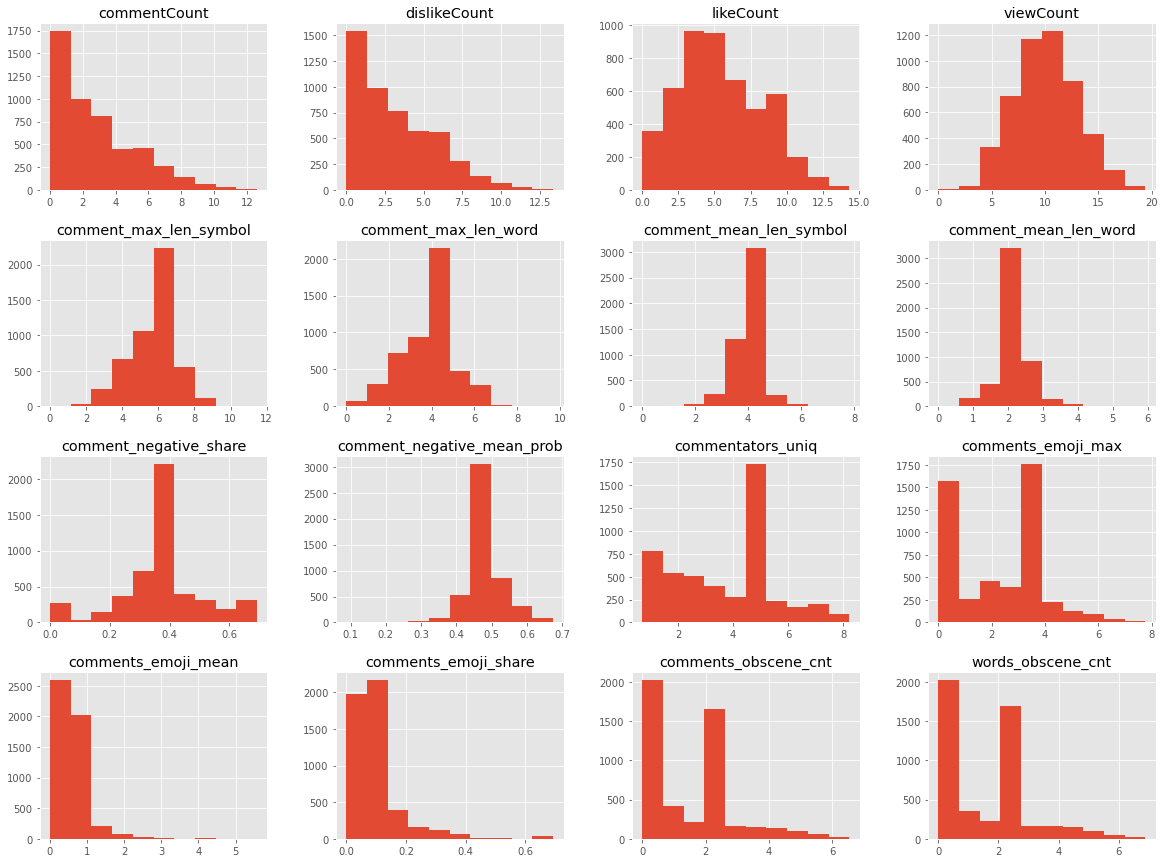

In [33]:
train[real_variables].hist(figsize = (20,15));

In [35]:
# объявляем метод 5 ближайших соседей
knn_no_out = KNeighborsClassifier(n_neighbors = 5)

# обучаем его по тренировочные выборке 
knn_no_out.fit(X_train, y_train)

# строим для тестовой выборки прогнозы 
y_pred_knn_no_out = knn_no_out.predict(X_test)

# прогнозы вероятностей
p_pred_knn_no_out = knn_norm.predict_proba(X_test) 
p_pred_knn_no_out = p_pred_knn_no_out[:, 1]  # P(y = 1 | X)

accuracy_score(y_test, y_pred_knn_no_out)

0.9021035598705501

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

__Внимание!__ В ячейке ниже будет несколько страшных функций для красивых картинок. Вы не обязаны разбираться в том, как они устроены. Но вот понимать что эти картинки обозначают и как метрики классификации работают, вы обязаны. 

In [34]:
import itertools

# Картинки для PR-кривой, а-меры и прочих ништяков
def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

__Внимание!__ Страшный кодище для картинок закончился. Начиная с этой строки, нужно снова начать понимать. У нас есть три функции: 

* `plot_confusion_matrix` строит матрицу ошибок
* `plot_precision_recall_curve` строит кривую точнось-полнота

Начнём с моделей. Будем смотреть на две: случайный лес и ближайшие соседи. 

In [35]:
# Начнёмс с того, что построим прогнозы 
p_pred_knn_norm = knn.predict_proba(X_test_norm)[:,-1]
p_pred_knn = knn.predict_proba(X_test)[:,-1]


Теперь сравним модели по площади под precision-recall кривой.

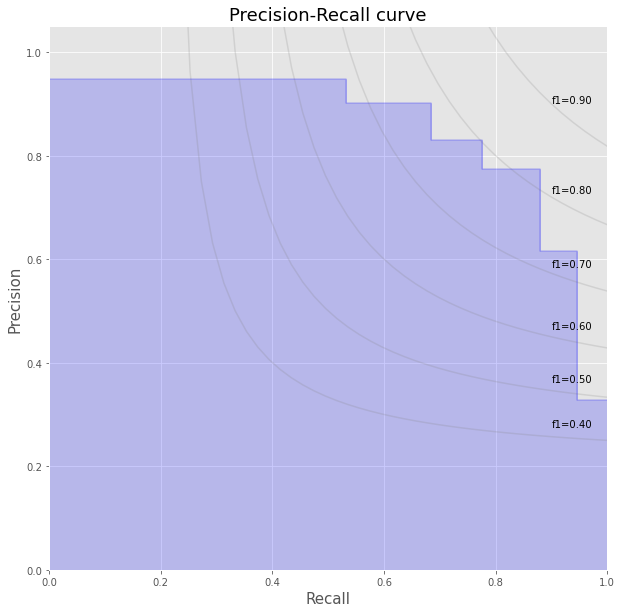

In [36]:
plot_precision_recall_curve(p_pred_knn_norm, y_test)

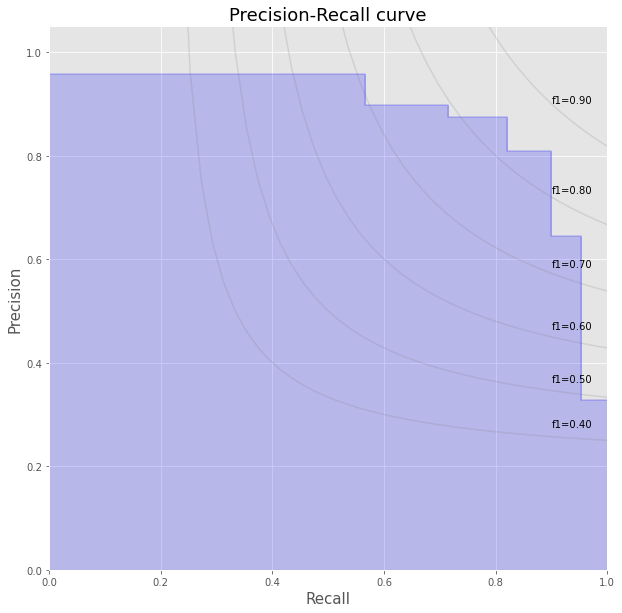

In [38]:
plot_precision_recall_curve(p_pred_knn_log, y_test)